# Default of Credit Card Clients Project - Group4

## I. Environment setup

In [2]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
import random
import plotly.express as px
import plotly.figure_factory as ff

ModuleNotFoundError: No module named 'plotly'

## II. Data import and preparation

In [19]:
df = pd.read_csv("data/default_of_credit_card_clients.csv", skiprows=1)

In [20]:
random.seed()

# rename column to get rid of spaces 

df.rename(columns = {"default payment next month":"default_payment"}, inplace = True)


# split into test and training set 

train_df, test_df = train_test_split(df, test_size=0.2)

X_train, y_train = (train_df.drop(columns=["default_payment"]),
                   train_df["default_payment"])

X_test, y_test = (test_df.drop(columns=["default_payment"]),
                  test_df["default_payment"])


The dataset was split into a 80% training and 20% testing set. The model will be built using only the training data. This gives the abilithy to compute a final performance metric for our model by evaluating it on the testing data. train_test_split() function shuffles the data to ensure the data ending up in the training and test sets is randomized. 

## III. Exploratory Data Analysis

### III-1. Dataset overview

First we have a look at our dataset:

In [21]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Then we check the number of rows and columns:

In [22]:
df.shape

(30000, 25)

Hence, there are 25 variables and 30,000 entries in this dataset.

### III-2. Check missing values

Now let's check if the dataset has null/missing values that may affect further analysis:

In [23]:
df.isnull().sum()

ID                 0
LIMIT_BAL          0
SEX                0
EDUCATION          0
MARRIAGE           0
AGE                0
PAY_0              0
PAY_2              0
PAY_3              0
PAY_4              0
PAY_5              0
PAY_6              0
BILL_AMT1          0
BILL_AMT2          0
BILL_AMT3          0
BILL_AMT4          0
BILL_AMT5          0
BILL_AMT6          0
PAY_AMT1           0
PAY_AMT2           0
PAY_AMT3           0
PAY_AMT4           0
PAY_AMT5           0
PAY_AMT6           0
default_payment    0
dtype: int64

Great! The dataset is super clean, and no missing value is found.

### III-3. Statistics information

This part we have a look at some basic statistics of the training set:

In [24]:
train_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,15006.491917,167545.986667,1.603500,1.853208,1.553750,35.494458,-0.010833,-0.130417,-0.161792,-0.218083,...,43245.773542,40248.295375,38851.290542,5643.784958,5.943125e+03,5207.485708,4837.368250,4790.171875,5196.007792,0.222667
std,8665.550187,129860.070567,0.489181,0.791109,0.522212,9.234484,1.123730,1.198771,1.195167,1.165796,...,64444.119197,60868.766907,59498.138271,16762.096488,2.422239e+04,17034.516105,16010.445847,15623.133922,17908.489522,0.416045
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7469.500000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2350.000000,1776.000000,1270.000000,1000.000000,8.270000e+02,390.000000,291.000000,264.000000,150.000000,0.000000
50%,15046.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19038.500000,18073.000000,17042.500000,2100.000000,2.010000e+03,1806.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,22556.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54272.000000,49956.750000,48941.250000,5005.000000,5.000000e+03,4505.750000,4000.000000,4000.000000,4000.000000,0.000000
max,30000.000000,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,7.000000,8.000000,8.000000,...,706864.000000,823540.000000,568638.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


We can see the following information:
1. The average amount of given credit in NT dollars is 166841.083333;
2. The average age of all clients is 35.484000, etc.

To better understand the correlation between variables, we would like to compute and visualize the correlations:

<AxesSubplot:>

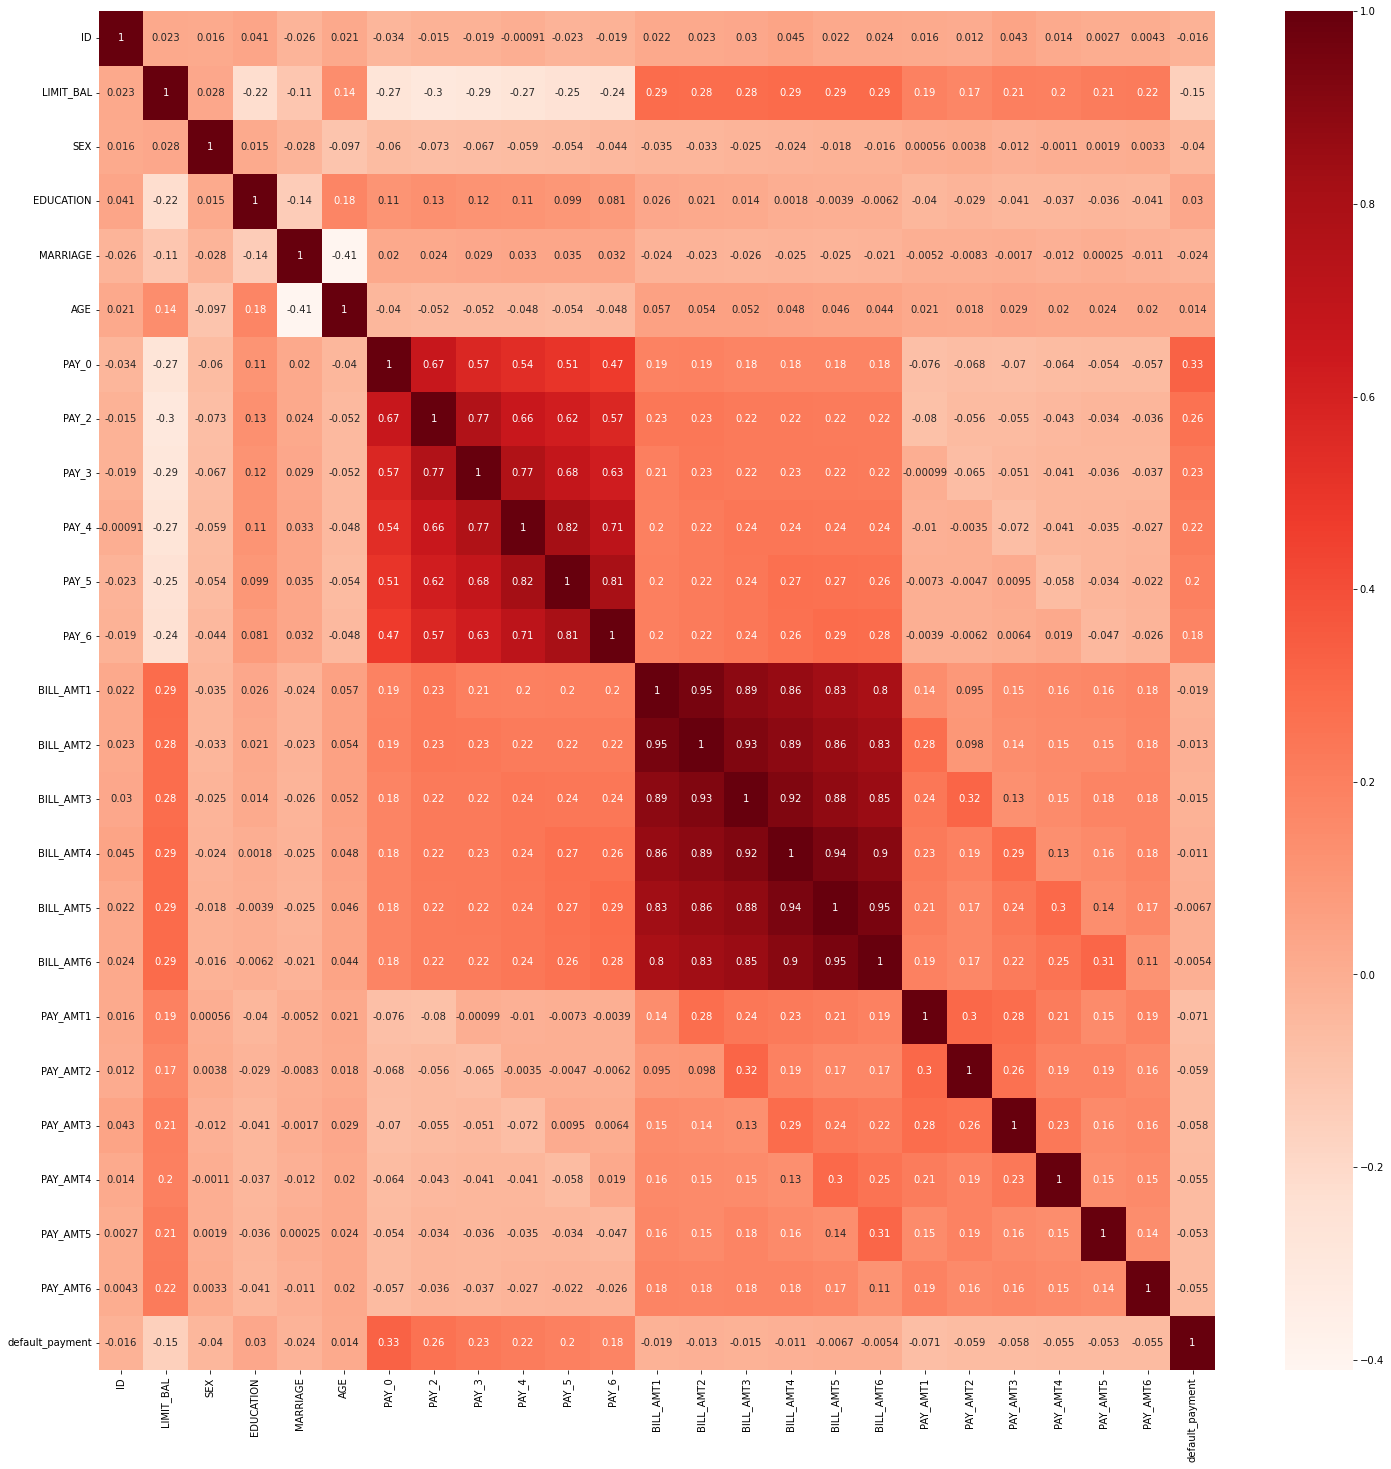

In [25]:
plt.figure(figsize=(25,25))
sns.heatmap(train_df.corr(),cbar=True,annot=True,cmap='Reds')

The heatmap shows some positive/negative correlations:

Positive correlations:
1. Default payment - PAY_0 to PAY_6 (Repayment status from April to September, 2005);
2. Limit balance - BILL_AMT1 to BILL_AMT6 (Amount of bill statement from April to September, 2005), etc.

Negative correlations:
1. Limit balance - PAY_0 to PAY_6 (Repayment status from April to September, 2005), etc.

Specifically, PAY_0 has the highest correlation with default_payment. This will give us a signal that PAY_0 plays an important role for predicting default_payment.


### III-4. Exploring variables

#### 1. LIMIT_BAL

First, we look at the amount of given credit (in NT dollars). Credit card limits are likely an indictor of how wealthy someone is since banks tend to give higher limits to clients that have more money with them. Thus, this may be an important feature when predicting if someone is able to pay the bill on time. 

/Users/hannahmartin/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/hannahmartin/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Density'>

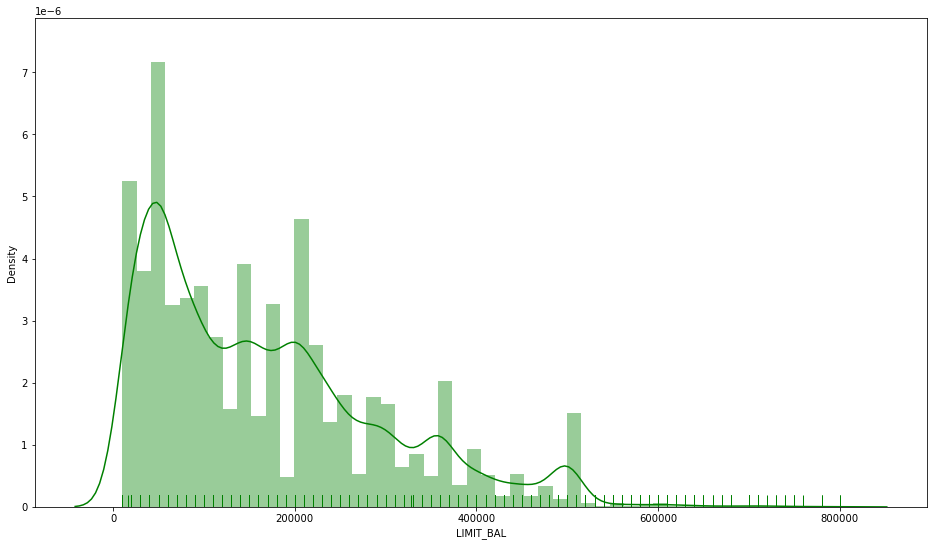

In [26]:
plt.figure(figsize = (16,9))
sns.distplot(train_df['LIMIT_BAL'],kde=True,bins=50, rug = True, color="green")

#### 2. Repayment Status

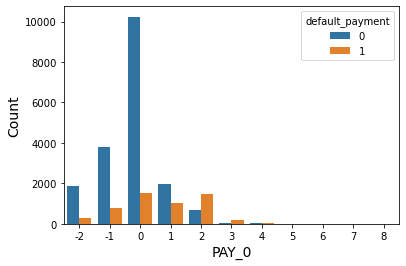

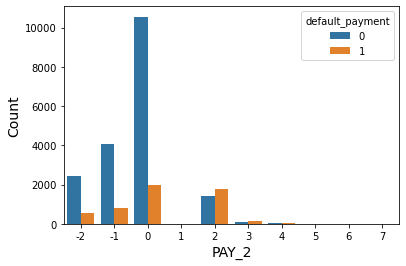

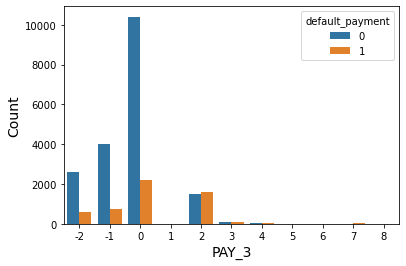

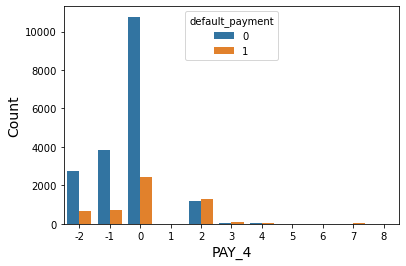

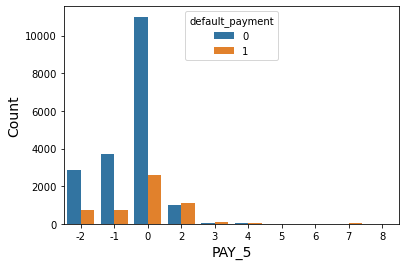

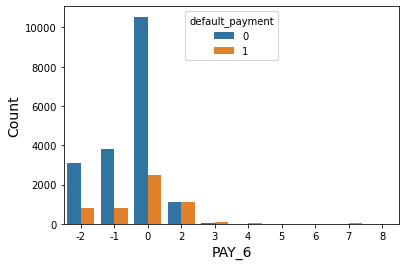

In [27]:
for column in train_df[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]]:
    edu_plot = sns.countplot(data = train_df, hue="default_payment", x = column)
    plt.xlabel(column, fontsize= 14)
    plt.ylabel("Count", fontsize= 14)
    plt.show()

Looking at the above plots on repayment status shows that if a client defaults on their payment for 2 months (e.g PAY_X = 2), it is a indicator to predict that default_payment = 1. It looks like repayment status will be an important feature in the model.

### Class Imbalance

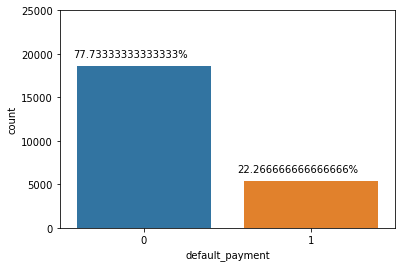

In [28]:
plt.figure(figsize=(6,4))

default_plot = sns.countplot(x = "default_payment",data = train_df)
plt.ylim(0,25000)
total = float(len(train_df))
for p in default_plot.patches:
    default_plot.annotate((str(100* p.get_height()/total) + "%"), (p.get_x()+0.32, p.get_height()+1000), ha="center")


plt.show()



The above plot shows the percentage of rows with default payment = 0 versus default payment = 1. Cleary there is class imbalance in this dataset. Because of this, we will use the area under the Receiver Operating Characterisitc curve (ROC AUC) as our primary metric to evaluate our model instead of accuracy, which tends to be missleading in cases of class imbalance. ROC AUC evalauates how good the model is as distinguishing between classes, and gives a more accurate sense of how well our model generalizes when dealing with class imbalance.

### Preprossesing 

We apply scaling to numeric features to ensure the model built will be robust and not sensitive to the scale of each individual feature. To do this, we use the StandardScaler() function to set the sample mean to 0 and standard deviation to 1.

To handle categorical values, we will apply one-hot-encoding. This creates binary dummy variables for each category. 

There are no null values in the dataset so there is no need to handle missing values. 

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 10665 to 27561
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               24000 non-null  int64
 1   LIMIT_BAL        24000 non-null  int64
 2   SEX              24000 non-null  int64
 3   EDUCATION        24000 non-null  int64
 4   MARRIAGE         24000 non-null  int64
 5   AGE              24000 non-null  int64
 6   PAY_0            24000 non-null  int64
 7   PAY_2            24000 non-null  int64
 8   PAY_3            24000 non-null  int64
 9   PAY_4            24000 non-null  int64
 10  PAY_5            24000 non-null  int64
 11  PAY_6            24000 non-null  int64
 12  BILL_AMT1        24000 non-null  int64
 13  BILL_AMT2        24000 non-null  int64
 14  BILL_AMT3        24000 non-null  int64
 15  BILL_AMT4        24000 non-null  int64
 16  BILL_AMT5        24000 non-null  int64
 17  BILL_AMT6        24000 non-null  int64
 18  PA

In [30]:
numeric_feats = [     # apply scaling
    "LIMIT_BAL",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4", 
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "AGE",
]

categorical_feats = [  # apply one-hot encoding
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "EDUCATION",
    "SEX",
    "MARRIAGE",
]

Next, we apply scaling and one-hot-encoding through using a column transformer, which applies the transformations to each column specified. 

In [31]:
ct = make_column_transformer(
    (StandardScaler(), numeric_feats,),
    (OneHotEncoder(handle_unknown="ignore"), categorical_feats,),

)

### Model 0: Dummy Classifier

Firstly, we will try a baseline model to act as a comparison measure for the final model built. Using a pipeline to do this ensures that the model is built using just the training data, and that the testing data has no influence on the model. 5-fold Cross validation is used to give a more robust measure of performance error. K-fold Cross-validation spilts the training data into k folds, and each time one fold is the validation set. Each fold fits the model on the training portion and uses one fold as a validation set to calculate a performance metric, which can be averaged to get a overall score of how well the model does. This ensures that outliers don't negatively influence the performance metric. 

In [32]:
from sklearn.model_selection import cross_val_predict

dummy = DummyClassifier()

pipe = make_pipeline(ct, dummy)

scores = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5, scoring="roc_auc")
scores = pd.DataFrame(scores)
scores

,fit_time,score_time,test_score,train_score
0,0.161459,0.039573,0.5,0.5
1,0.080017,0.024940,0.5,0.5
2,0.112306,0.044101,0.5,0.5
3,0.110048,0.024468,0.5,0.5
4,0.071458,0.021697,0.5,0.5


### Model 1: Logistic Regression

Next, a logistic regression model is fitted to the training data. Logistic regression uses the training data to learn coefficients, which then can be used to calculate prediction probabilities of the each class using the sigmoid function. This allows us to calculate the probability of a client defaulting on their credit card based on their data. The hyperparameter C is used to control the fundatamental tradeoff of bias and variance, to reduce the likeliness of the model overfitting or underfitting. We chose logistic regression over more complex classifiers such as ensemble trees because it is easier to interpret and efficient to train. The predicted coeficients give information about feature importance and direction of association, making the model easily interpreted. Moreover, since the dataset is significantly larger than the number of features, logistic regression is less likely to overfit because it is a low variance model.

Hyperparameter optimization is carried out to find the best value of C for the data in hopes to reduce bias and variance. Cross-validation is used to test how well the model performs on unseen data during hyperparemter opimization, enabling performance metrics to be calculated to compare different values of C.

In [33]:
random.seed()

train_scores = []
cv_scores = []

C = 10.0 ** np.arange(-1.5, 2, 0.5)

for c in C:
    
    pipe_lr = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=c),
    )
    
    results = cross_validate(pipe_lr, X_train, y_train, return_train_score=True, scoring = "roc_auc")
    
    train_scores.append(results["train_score"].mean())
    cv_scores.append(results["test_score"].mean())
    

scores = pd.DataFrame({"C": C, "Train Scores": train_scores, "CV Scores": cv_scores })

scores

,C,Train Scores,CV Scores
0,0.031623,0.771588,0.768261
1,0.100000,0.772033,0.768378
2,0.316228,0.772192,0.768226
3,1.000000,0.772274,0.767884
4,3.162278,0.772309,0.767574
5,10.000000,0.772349,0.767151
6,31.622777,0.772400,0.766683


In [34]:
best_C = scores.loc[scores["CV Scores"].idxmax(), "C"]
print("best C value: " + str(best_C))

best C value: 0.1


Next, the logistic regression model with the optimized C value is fitted to the training data. The model is built using pipelines to ensure all data preprocessing is constant and that no information from the testing set leaks into the training of the model.

In [35]:
model = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=best_C),
    )

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'BILL_AMT1',
                                                   'BILL_AMT2', 'BILL_AMT3',
                                                   'BILL_AMT4', 'BILL_AMT5',
                                                   'BILL_AMT6', 'PAY_AMT1',
                                                   'PAY_AMT2', 'PAY_AMT3',
                                                   'PAY_AMT4', 'PAY_AMT5',
                                                   'PAY_AMT6', 'AGE']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'P

### Feature Importance

Next, we will look at feature importance. In logistic regression, the magnitude and direction of the learned coefficients explain the relationship between a explanatory feature and the response variable.

In [36]:
ohe_feature_names = (
    model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names()
    .tolist()
)


feat_names = (numeric_feats + ohe_feature_names)

In [37]:
coefs = {
    "coefficient": model.named_steps["logisticregression"].coef_[0].tolist(),
    "absolute_value": np.absolute(
        model.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
df_coefs = pd.DataFrame(coefs, index=feat_names).sort_values(
    "absolute_value", ascending=False
)

df_coefs[:10]

,coefficient,absolute_value
x0_0,-1.134121,1.134121
x0_2,1.054884,1.054884
x0_-2,-0.929142,0.929142
x0_3,0.867484,0.867484
x6_5,-0.509471,0.509471
x0_-1,-0.444408,0.444408
x6_4,-0.349790,0.349790
x0_4,0.342581,0.342581
x6_2,0.331846,0.331846
x1_4,-0.317032,0.317032


The table above shows the most important features according to the model. Positive coefficients indicate that an increase in the feature increases the probability that the response variable is class 1, and negative coefficients indicate that a increases in the feature decreases the probability that the response variable is class 1.

The most important feature is repayment status in April with a 2 month delay.

x0_2 $= \begin{cases}
    1     &\text{if repayment status in April was delayed 2 months} \\
    0     &\text{else}
    \end{cases}$

To further interpret this, the odds ratio can be calculated. $OR = e^{\beta}$,  where $\beta$ is a model coefficient.

In [38]:
x0_2_OR = np.exp(df_coefs.iat[0,0])
x0_2_OR

0.32170464678415917

The odds ratio for x0_2 can be interpreted as clients who delayed payment for 2 months in April have 2.9 times the odds of defaulting their credit card payment next month than those who did not delay for 2 months of, controlling for the other features since there is some correlation.

It makes logical sense that this feature is important since it was highly correlated with the response variable during the exploratory data analysis, and because it makes sense that if someone has delayed payment in the past they may not be able to pay in the future as well.

Another important feature is x0_0, corresponding to repayment status in April with a revolving credit. The magnitude is negative here meaning that a value of 1 for this binary variable is negatively associated with defaulting next month. This makes sense because revolving credit lets clients pay a minimum balance instead of the full bill, making them less likely to default. The odds ratio is calculated below.

In [39]:
x0_0_OR = np.exp(df_coefs.iat[1,0])
x0_0_OR

2.8716427000569342

The odds ratio above shows that clients who had a repayment status of using a revolving credit in April decreases the odds of class 1 versus class 0 by about 65%, controlling for the other features.

Due to the large number of features, we only looked at the first 2 most important features, however this method can be done for the remaining features as well.

### Testing the Model

Finally, the model will be evaluated by predicting on the test dataset. Performance metrics including area under the ROC curve, f1-score, precision and recall will be calculated. Precision is the ratio of true postive and total positives. Recall is the measure of the model correctly identifying true positives. F1-score is the harmonic mean of precision and recall.

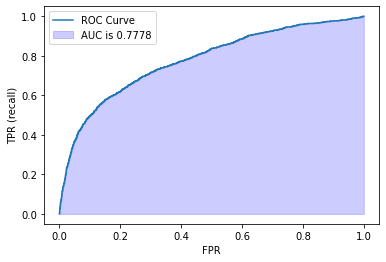

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# prediction probabilities on test set 
lr_prob = model.predict_proba(X_test)[:,1]

# roc_auc score on test set 
roc_lr = roc_auc_score(y_test, lr_prob)

fpr, tpr, thresholds = roc_curve(y_test, lr_prob)

roc_lr = round(roc_lr, 4)

auc_label = "AUC is " + str(roc_lr)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.fill_between(fpr, tpr, color='blue', alpha=0.2, label=auc_label)

plt.legend(loc="best");

The test ROC AUC is almost the same as the cross-validation ROC AUC so we can conclude that there is little optimization bias and we are not overfitting. Area under the ROC curve is the classifier's ability to distinguish between classes. So 78% of the time, the model is able to correctly distinguish between class 0 and class 1.

In [42]:
predict = model.predict(X_test)

res = classification_report(
        y_test, predict, target_names=["non-default", "default"]
    )

print(res)

              precision    recall  f1-score   support

 non-default       0.84      0.95      0.90      4708
     default       0.68      0.36      0.47      1292

    accuracy                           0.83      6000
   macro avg       0.76      0.66      0.68      6000
weighted avg       0.81      0.83      0.80      6000



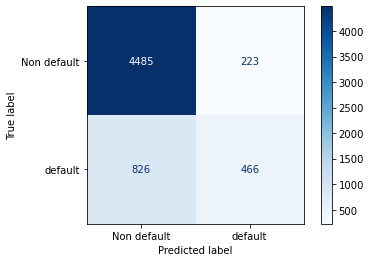

In [43]:
plot_confusion_matrix(
    model,
    X_test,
    y_test,
    display_labels=["Non default", "default"],
    values_format="d",
    cmap=plt.cm.Blues,
);

 It appears that the model does significantly better for the non-default class, since precision, recall, and f1-score are very high. Recall is partically low for the default class, and very high for the non-default class. Thus this model is very good at indentifying clients who will pay their bill on time. Precision can be intrepreted as when the model predicts class 0 (non-default) it is correct 84% of the time, and when it predicts class 1 it is correct 64% of the time, which is not as good. 